# Project: K-Means Clustering on the Sporulation Dataset

This project involves applying the **K-Means clustering algorithm** to the **sporulation dataset**, which contains gene expression data from yeast during the process of sporulation. The primary objective of this analysis is to explore how well the K-Means algorithm can cluster the genes based on their temporal expression patterns and compare the clustering results with published biological classifications.

## Steps:

- **Preprocessing the data**: This involves cleaning the dataset, converting string values to numerical format, and handling any outliers or irregular data, such as mean and standard deviation rows.
- **Applying the K-Means algorithm**: The data is clustered into groups using K-Means, where the number of clusters is set to 7 based on biological relevance (following the literature).
- **Visualize the K-Means clusters**: The clusters created by K-Means algorithm are briefly visualized on a 2-dimensional plane.
- **Evaluating clustering performance**: The clustering results are evaluated using the **silhouette index** to assess the quality and coherence of the clusters.
- **Comparison with existing research**: The obtained clusters are compared with the results from the research paper "Comparisons and validation of statistical clustering techniques for microarray gene expression data" by Datta & Datta (2003), which evaluated various clustering techniques on the same dataset. (unfiltered)

### Preprocessing the data  

##### Load the filtered sporulation dataset

In [5]:
import numpy as np
import pandas as pd

# Load the sporulation dataset
df = pd.read_csv('sporulation-filtered.txt', sep='\t')

# Drop the 'Genes' column, as KMeans only works with numerical data
X = df.drop(columns=['Genes'])

# Convert the values from string to float
# Replace ',' with '.' so that the values can be converted to float
X.replace({',': '.'}, regex=True, inplace=True)
X = X.iloc[:-2,:]
X = X.astype(float)

# Number of clusters
clusters = 7
# Number of genes
M = len(X.iloc[:, 0])
# number of Time dimensions
l = len(X.iloc[0, :])

print('Number of genes:', M)
print('Number of time dimensions:', l)


# Create a list of gene data without one of the time steps
# t0 t0,5 t2 t5 t7 t9 t11,5
X_without_time_step = [X.drop(columns=['t0']), 
                       X.drop(columns=['t0,5']), 
                       X.drop(columns=['t2']), 
                       X.drop(columns=['t5']), 
                       X.drop(columns=['t7']), 
                       X.drop(columns=['t9']), 
                       X.drop(columns=['t11,5'])]
    
X.tail()

Number of genes: 474
Number of time dimensions: 7


,t0,"t0,5",t2,t5,t7,t9,"t11,5"
469,1.473570,-0.980588,0.187547,-0.775976,-1.067287,0.126038,1.036696
470,1.543327,-1.090000,-0.374713,-0.780946,-0.671057,0.308319,1.065071
471,1.855230,-0.550056,-0.264951,-1.042622,-0.729874,-0.019525,0.751798
472,1.785611,-0.406223,-0.895333,-0.585125,-0.816870,0.003997,0.913943
473,1.552631,-0.019515,-0.392120,-1.218152,-0.896972,-0.092712,1.066840


##### Use the K-means algorithm on the filtered dataset

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use the KMeans algorithm to cluster the data
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(X)
X_clustered = kmeans.predict(X)

X_clustered_without_time_step = [0 for i in range(l)]
for i in range(len(X_without_time_step)):
    kmeans_without = KMeans(n_clusters=7)
    kmeans_without.fit(X_without_time_step[i])
    X_clustered_without_time_step[i] = kmeans_without.predict(X_without_time_step[i])

#### Visualize the K-Means clusters

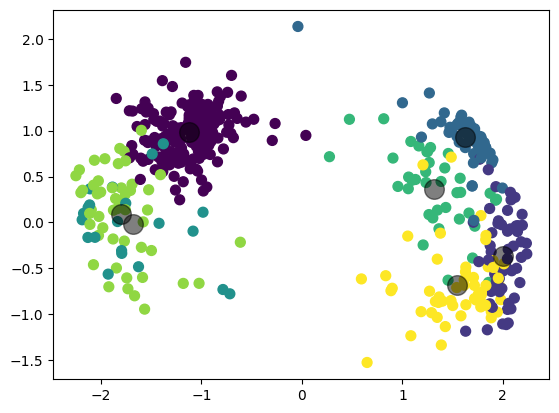

In [7]:
import matplotlib.pyplot as plt

# Plot the clusters in a two-dimensional space
dim1, dim2 = 0, 6 # can be any two dimensions
plt.scatter(X.iloc[:, dim1], X.iloc[:, dim2], c=X_clustered, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, dim1], centers[:, dim2], c='black', s=200, alpha=0.5)

plt.show()

#### Evaluating clustering performance
Evaluate the quality of the clusters using the silhoutte index

In [8]:
# Calculate the silhouette score
base_silhoutte = silhouette_score(X, X_clustered)

silhoutte_without_time_step = [0 for i in range(l)]
for i in range(len(X_without_time_step)):
    silhoutte_without_time_step[i] = silhouette_score(X_without_time_step[i], X_clustered_without_time_step[i])
    
    print("Silhoutte score for kmeans using the dataset without time step %i: " % (i + 1), silhoutte_without_time_step[i])

print("Silhoutte score for kmeans using the whole dataset: ", base_silhoutte)



Silhoutte score for kmeans using the dataset without time step 1:  0.26231508375687174
Silhoutte score for kmeans using the dataset without time step 2:  0.2602476129954298
Silhoutte score for kmeans using the dataset without time step 3:  0.2502349123582802
Silhoutte score for kmeans using the dataset without time step 4:  0.2992778799874703
Silhoutte score for kmeans using the dataset without time step 5:  0.4254854149356849
Silhoutte score for kmeans using the dataset without time step 6:  0.4264311690949888
Silhoutte score for kmeans using the dataset without time step 7:  0.3867441954984694
Silhoutte score for kmeans using the whole dataset:  0.404843988770265


## Comparison with existing research
Calculate the average proportion of non-overlap measure  
V1(K) = 1/(M*l) * sum_{g=1}^{M}(sum_{i=1}^{l}(1-n(C_g,i intersection C_g,0)/(n*C_g,0)))  

In [9]:
# Calculate the average proportion of non-overlap measure
# V1(K) = 1/(M*l) * sum_{g=1}^{M}(sum_{i=1}^{l}(1-n(C_g,i intersection C_g,0)/(n*C_g,0)))
# l = 7 is the number of dims (time steps)
# M = 474 is the number of genes
# C_g,i denote the cluster containing gene g in the clustering based on the data set with time Ti observations deleted.

average_proportion_non_overlap = 0
for g in range(M):
    # Get the original elements of a cluster C_g_0
    cluster_g_0 = (X_clustered == X_clustered[g])
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        cluster_g_i = (X_clustered_without_time_step[i] == X_clustered_without_time_step[i][g])

        # Calculate the number of elements in the intersection of the two clusters
        intersection_of_Cs = sum([a and b for a, b in zip(cluster_g_0, cluster_g_i)])

        average_proportion_non_overlap += 1/(M*l) * (1 - intersection_of_Cs/(sum(cluster_g_0)))
average_proportion_non_overlap

np.float64(0.2238380586619172)

Calculate the average distance between means measure between means  
V2(K) = 1/Ml*sum_g=1..M (sum_i=1..l(d(mean(C_g,i),mean(C_g,0))))  

In [10]:
from scipy.spatial.distance import euclidean

# The average distance between means measure between means
# V2(K) = 1/Ml*sum_g=1..M (sum_i=1..l(d(mean(C_g,i),mean(C_g,0))))
average_distance_between_means = 0

for g in range(M):
    # Create a bool array with True for the elements in the cluster C_g_0
    C_g_0 = (X_clustered == X_clustered[g])
    # Filter the data frame with the bool array to get the genes in the cluster C_g_0
    C_g_0 = X.iloc[C_g_0]
    # Calculate the mean of every time step of the genes in the cluster C_g_0 
    mean_C_g_0 = [0 for i in range(l)]
    for i in range(l):
        mean_C_g_0[i] = np.mean(C_g_0.iloc[:, i])

    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        # Create a bool array with True for the elements in the cluster C_g_i
        C_g_i = (X_clustered_without_time_step[i] == X_clustered_without_time_step[i][g])
        # Filter the data frame with the bool array to get the genes in the cluster C_g_i
        C_g_i = X.iloc[cluster_g_i]
        # Calculate the mean of every time step of the genes in the cluster C_g_i 
        mean_C_g_i = [0 for i in range(l)]
        for j in range(l):
            mean_C_g_i[j] = np.mean(C_g_i.iloc[:, j])
        
        average_distance_between_means += 1/(M*l) * euclidean(mean_C_g_0, mean_C_g_i)
average_distance_between_means

2.731303416867689

Calculate the average distance measure  
V3(K) = 1/Ml*sum_g=1..M (sum_i=1..l(1/(n(C_g,i)n(C_g,0))*sum_{g' element of C_g,i, g element of C_g,0}d(x_g,x_g')))  

In [11]:
# The average distance measure
# V3(K) = 1/Ml*sum_g=1..M (sum_i=1..l(1/(n(C_g,i)n(C_g,0))*sum_{g' element of C_g,i, g element of C_g,0}d(x_g,x_g')))
average_distance_measure = 0
for g in range(M):
    # Calculate the number of elements in the cluster C_g_0
    C_g_0 = (X_clustered == X_clustered[g])
    n_C_g_0 = sum(cluster_g_0)
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        # Calculate the number of elements in the cluster C_g_i
        C_g_i = (X_clustered_without_time_step[i] == X_clustered_without_time_step[i][g])
        n_C_G_i = sum(cluster_g_i)

        # Calculate the sum of distances d(x_g, x_g') for genes in the same cluster in both full and reduced datasets
        distance_sum = 0
        for g_prime in range(M):
            if cluster_g_i[g_prime]:
                # Compute the distance between the expression profiles of gene g and g'
                distance_sum += euclidean(X.iloc[g, :], X.iloc[g_prime, :])  # Use Euclidean distance, but can use another metric

        # Add to the average distance measure formula
        average_distance_measure += (1 / (M * l)) * (1 / (n_C_g_0 * n_C_G_i)) * distance_sum
average_distance_measure

np.float64(0.051402116545691386)

In [12]:
from itertools import permutations